### Convert Sentisense file To CSV


In [38]:
import pandas as pd
import xml.etree.ElementTree as ET
from sklearn.preprocessing import MinMaxScaler
from mlxtend.preprocessing import TransactionEncoder
from nltk.tokenize import word_tokenize
from collections import Counter

In [39]:
# Parse SentiSense Categories
def parse_categories(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()

    categories = []
    for category in root.findall('EmotionalCategory'):
        categories.append({
            'name': category.attrib['name'],
            'antonym': category.attrib.get('antonym', None)
        })

    df_categories = pd.DataFrame(categories)
    df_categories.to_csv('SentiSense_Categories.csv', index=False)
    print("Categories saved to SentiSense_Categories.csv")

# Parse SentiSense Synsets
def parse_synsets(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()

    synsets = []
    for concept in root.findall('Concept'):
        synsets.append({
            'synset': concept.attrib['synset'],
            'pos': concept.attrib['pos'],
            'gloss': concept.attrib['gloss'],
            'emotion': concept.attrib['emotion']
        })

    df_synsets = pd.DataFrame(synsets)
    df_synsets.to_csv('SentiSense_Synsets.csv', index=False)
    print("Synsets saved to SentiSense_Synsets.csv")

# Convert XML to CSV
parse_categories('/Users/sumeyyasherief/DataspellProjects/MLfinalproject/SentiSense_English_WordNet_2.1/SentiSense_Categories.xml')
parse_synsets('/Users/sumeyyasherief/DataspellProjects/MLfinalproject/SentiSense_English_WordNet_2.1/SentiSense_Synsets_EN_21.xml')


Categories saved to SentiSense_Categories.csv
Synsets saved to SentiSense_Synsets.csv


### Load CSV files

In [40]:
categories_df = pd.read_csv('SentiSense_Categories.csv')
synsets_df = pd.read_csv('SentiSense_Synsets.csv')
print(categories_df.head())
print(synsets_df.head())

df = pd.read_csv('Music.csv', header=0, low_memory=False)
print(df.head())
# Drop irrelevant columns
df = df.drop(['id', 'track_id'], axis=1)
df = df.dropna()
#print(df.columns)

# Normalize features
scaler = MinMaxScaler()
features = ['valence', 'energy', 'tempo']
df[features] = scaler.fit_transform(df[features])
\

       name       antonym
0       joy       sadness
1      fear      calmness
2  surprise  anticipation
3     anger      calmness
4   disgust          like
           synset        pos  \
0  SID-00152712-A  adjective   
1  SID-00050667-R     adverb   
2  SID-00870909-N       noun   
3  SID-05777543-N       noun   
4  SID-02414842-A  adjective   

                                               gloss       emotion  
0  lacking cordiality; unfriendly; "a standoffish...       disgust  
1         in a joyous manner; "they shouted happily"           joy  
2  the activities of educating or instructing; ac...          like  
3  a characteristic that provides pleasure and at...  anticipation  
4  of a quantity that can fulfill a need or requi...  anticipation  
   id                track_id                 artists  \
0   0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1   1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2   2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3   3  6l

### Mapping Songs to emotions

In [49]:
# Map songs to emotions based on thresholds (example logic)
def map_emotions(row):
    if row['valence'] > 0.7 and row['energy'] < 0.3:
        return 'calm'
    elif row['valence'] > 0.7 and row['energy'] > 0.7:
        return 'joyful'
    elif row['valence'] < 0.3 and row['energy'] > 0.7:
        return 'angry'
    elif row['valence'] < 0.3 and row['energy'] < 0.3:
        return 'sad'
    else:
        return 'neutral'

df['emotion'] = df.apply(map_emotions, axis=1)


In [53]:
print(df.columns) 

Index(['artists', 'album_name', 'track_name', 'popularity', 'duration_ms',
       'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'track_genre', 'text_data',
       'emotion_cluster', 'emotion_label', 'emotion'],
      dtype='object')


### Encode Transactions for Apriori Algorithm

In [69]:

import numpy as np

music_df = pd.read_csv('Music.csv')
# Group by user preferences and create transactional data
# Example: Assuming there's a `user_id` column and each user listens to multiple songs
user_transactions = df.groupby('user_id')['emotion'].apply(list).reset_index()

# Ensure each user's emotion list contains unique emotions
user_transactions['emotion'] = user_transactions['emotion'].apply(lambda x: list(set(x)))

# Save transactional data
user_transactions.to_csv('User_Transactions.csv', index=False)

# Display the transactional data
print(user_transactions.head())

   user_id                              emotion
0        1  [angry, sad, joyful, neutral, calm]
1        2  [angry, sad, joyful, neutral, calm]
2        3  [sad, angry, joyful, neutral, calm]
3        4  [sad, angry, joyful, neutral, calm]
4        5  [sad, angry, joyful, neutral, calm]


In [71]:
import random

# Simulate user transactions with random emotions
emotions = ['angry', 'calm', 'joyful', 'neutral', 'sad']
user_transactions = pd.DataFrame({
    'user_id': [1, 2, 3, 4, 5],
    'emotion': [random.sample(emotions, random.randint(2, 5)) for _ in range(5)]
})

# Save the simulated transactions
user_transactions.to_csv('User_Transactions.csv', index=False)

print(user_transactions)


   user_id                              emotion
0        1          [sad, angry, neutral, calm]
1        2              [neutral, calm, joyful]
2        3  [sad, calm, joyful, neutral, angry]
3        4  [neutral, sad, calm, joyful, angry]
4        5           [joyful, angry, calm, sad]


In [72]:
from mlxtend.preprocessing import TransactionEncoder
import pandas as pd

# Load the regenerated transactional data
user_transactions = pd.read_csv('User_Transactions.csv')

# Extract the list of emotion transactions
transactions = user_transactions['emotion'].apply(eval).tolist()

# Ensure each transaction has unique emotions
transactions = [list(set(t)) for t in transactions]

# Check unique transactions
print("Unique transactions:", transactions[:5])

# Initialize TransactionEncoder
te = TransactionEncoder()

# Fit and transform transactions
te_array = te.fit(transactions).transform(transactions)

# Debug: Check detected columns
print("Detected columns:", te.columns_)

# Convert the binary matrix to a DataFrame
df_encoded = pd.DataFrame(te_array, columns=te.columns_)

# Convert True/False to 1/0
df_encoded = df_encoded.astype(int)

# Save the encoded transactions
df_encoded.to_csv('Encoded_Transactions.csv', index=False)

# Display the final DataFrame
print(df_encoded.head())


Unique transactions: [['calm', 'sad', 'neutral', 'angry'], ['neutral', 'calm', 'joyful'], ['sad', 'angry', 'joyful', 'neutral', 'calm'], ['angry', 'sad', 'joyful', 'neutral', 'calm'], ['calm', 'joyful', 'angry', 'sad']]
Detected columns: ['angry', 'calm', 'joyful', 'neutral', 'sad']
   angry  calm  joyful  neutral  sad
0      1     1       0        1    1
1      0     1       1        1    0
2      1     1       1        1    1
3      1     1       1        1    1
4      1     1       1        0    1


### Apply the Apriori Algorithm

In [90]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import mlxtend

def generate_rules(df_encoded, min_support=0.1, min_confidence=0.5):
    """
    Generate frequent itemsets and association rules with compatibility for different mlxtend versions
    
    Parameters:
    -----------
    df_encoded : pd.DataFrame
        The encoded transaction data
    min_support : float
        Minimum support threshold for frequent itemsets
    min_confidence : float
        Minimum confidence threshold for rules
        
    Returns:
    --------
    tuple : (frequent_itemsets, rules)
    """
    try:
        # Generate frequent itemsets
        frequent_itemsets = apriori(df_encoded,
                                    min_support=min_support,
                                    use_colnames=True)

        if len(frequent_itemsets) == 0:
            print("No frequent itemsets found. Try lowering the min_support threshold.")
            return None, None

        # Add length column
        frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

        # Check mlxtend version and call association_rules accordingly
        mlxtend_version = tuple(map(int, mlxtend.__version__.split('.')))

        try:
            if mlxtend_version >= (0, 21, 0):  # Newer versions
                rules = association_rules(frequent_itemsets,
                                          metric="confidence",
                                          min_threshold=min_confidence)
            else:  # Older versions
                # Count number of transactions
                num_transactions = len(df_encoded)

                rules = association_rules(frequent_itemsets,
                                          metric="confidence",
                                          min_threshold=min_confidence,
                                          num_itemsets=num_transactions)

            if len(rules) > 0:
                rules = rules.sort_values(['confidence', 'lift'], ascending=[False, False])
                return frequent_itemsets, rules
            else:
                print("No rules found. Try lowering the confidence threshold.")
                return frequent_itemsets, None

        except TypeError:  # Fallback method if version detection fails
            num_transactions = len(df_encoded)
            rules = association_rules(frequent_itemsets,
                                      metric="confidence",
                                      min_threshold=min_confidence,
                                      num_itemsets=num_transactions)

            if len(rules) > 0:
                rules = rules.sort_values(['confidence', 'lift'], ascending=[False, False])
            return frequent_itemsets, rules

    except Exception as e:
        print(f"Error generating rules: {str(e)}")
        return None, None

# Example usage with very low thresholds to ensure we find patterns
try:
    print("Generating rules...")
    print(f"Using mlxtend version: {mlxtend.__version__}")

    # First try with very low thresholds
    frequent_itemsets, rules = generate_rules(
        df_encoded,
        min_support=0.01,  # Very low support threshold
        min_confidence=0.1  # Very low confidence threshold
    )

    if frequent_itemsets is not None:
        print("\nFrequent Itemsets Found:", len(frequent_itemsets))
        print(frequent_itemsets.head())

        if rules is not None:
            print("\nRules Found:", len(rules))
            print("\nTop 5 rules by confidence:")
            print(rules.head())

            # Print statistics
            print("\nRule Statistics:")
            print(f"Number of rules: {len(rules)}")
            print(f"Average confidence: {rules['confidence'].mean():.3f}")
            print(f"Average lift: {rules['lift'].mean():.3f}")
        else:
            print("\nNo rules generated with current thresholds.")

        # If no rules were found, try with even lower thresholds
        if rules is None or len(rules) == 0:
            print("\nTrying with extremely low thresholds...")
            frequent_itemsets, rules = generate_rules(
                df_encoded,
                min_support=0.001,  # Extremely low support threshold
                min_confidence=0.05  # Extremely low confidence threshold
            )

            if rules is not None and len(rules) > 0:
                print("\nRules found with lower thresholds:")
                print(rules.head())
    else:
        print("No frequent itemsets found. Please check your encoded data.")
        print("\nSample of encoded data:")
        print(df_encoded.head())
        print("\nShape of encoded data:", df_encoded.shape)

except Exception as e:
    print(f"Error in main execution: {str(e)}")

Generating rules...
Using mlxtend version: 0.23.2

Frequent Itemsets Found: 31
   support   itemsets  length
0      0.8    (angry)       1
1      1.0     (calm)       1
2      0.8   (joyful)       1
3      0.8  (neutral)       1
4      0.8      (sad)       1

Rules Found: 180

Top 5 rules by confidence:
      antecedents  consequents  antecedent support  consequent support  \
6         (angry)        (sad)                 0.8                 0.8   
7           (sad)      (angry)                 0.8                 0.8   
32  (angry, calm)        (sad)                 0.8                 0.8   
34    (sad, calm)      (angry)                 0.8                 0.8   
35        (angry)  (sad, calm)                 0.8                 0.8   

    support  confidence  lift  representativity  leverage  conviction  \
6       0.8         1.0  1.25               1.0      0.16         inf   
7       0.8         1.0  1.25               1.0      0.16         inf   
32      0.8         1.0  1.25  

### Visualize Results

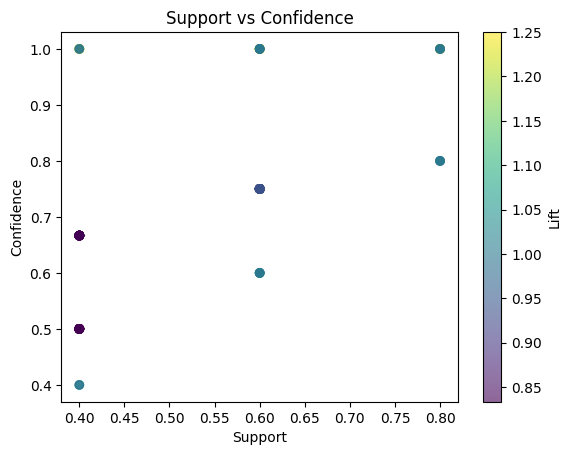

In [91]:
import matplotlib.pyplot as plt

plt.scatter(rules['support'], rules['confidence'], alpha=0.6, c=rules['lift'], cmap='viridis')
plt.colorbar(label='Lift')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Support vs Confidence')
plt.show()


### Create the Recommendation System

In [92]:
import pandas as pd

def recommend_emotions(user_emotions, rules, top_n=5):
    """
    Recommend emotions based on user input and association rules.

    Parameters:
    -----------
    user_emotions : list
        List of emotions the user is experiencing.
    rules : pd.DataFrame
        The association rules DataFrame generated in Step 3.
    top_n : int
        Number of top recommendations to return.

    Returns:
    --------
    pd.DataFrame
        Top N recommended emotions with confidence and lift.
    """
    # Convert user emotions to frozenset for comparison with antecedents
    user_emotions_set = frozenset(user_emotions)

    # Filter rules where the antecedents match the user's emotions
    applicable_rules = rules[rules['antecedents'].apply(lambda x: user_emotions_set.issubset(x))]

    if applicable_rules.empty:
        print("No recommendations could be generated with the given emotions.")
        return None

    # Sort by confidence and lift
    recommendations = applicable_rules[['consequents', 'confidence', 'lift']].sort_values(
        by=['confidence', 'lift'], ascending=[False, False]
    )

    # Return the top N recommendations
    return recommendations.head(top_n)


# Example Usage
if __name__ == "__main__":
    # Example user emotions
    user_emotions = ['angry', 'calm']

    # Use the rules DataFrame generated in Step 3
    # Ensure the 'antecedents' and 'consequents' columns are frozensets
    rules['antecedents'] = rules['antecedents'].apply(frozenset)
    rules['consequents'] = rules['consequents'].apply(frozenset)

    # Get recommendations
    recommendations = recommend_emotions(user_emotions, rules, top_n=5)

    if recommendations is not None:
        print("Top Recommendations:")
        print(recommendations)


Top Recommendations:
       consequents  confidence  lift
32           (sad)        1.00  1.25
97           (sad)        1.00  1.25
108          (sad)        1.00  1.25
154          (sad)        1.00  1.25
101  (sad, joyful)        0.75  1.25


### Validate the Recommendation System

In [96]:
from sklearn.metrics import precision_score, recall_score, f1_score

def validate_recommendation_system(user_emotion_data, recommendations, music_df):
    """
    Validate the recommendation system using precision, recall, and F1 score.

    Parameters:
    -----------
    user_emotion_data : dict
        A dictionary where keys are user IDs and values are lists of actual emotions.
    recommendations : pd.DataFrame
        The recommendations generated by the recommendation system.
    music_df : pd.DataFrame
        Original dataset with song emotions.

    Returns:
    --------
    dict
        A dictionary containing precision, recall, F1 score, and coverage.
    """
    all_actual = []
    all_predicted = []

    for user_id, actual_emotions in user_emotion_data.items():
        # Get recommendations for the user (handle cases where no recommendations exist)
        user_recommendations = recommendations.loc[user_id]['recommended_emotions'] if user_id in recommendations.index else []

        # Append actual emotions
        all_actual.extend(actual_emotions)

        # Append predictions for existing emotions
        all_predicted.extend(user_recommendations)

    # Ensure consistent lengths by adding default predictions (or filtering)
    if len(all_actual) != len(all_predicted):
        min_length = min(len(all_actual), len(all_predicted))
        all_actual = all_actual[:min_length]
        all_predicted = all_predicted[:min_length]

    # Calculate precision, recall, and F1 score
    precision = precision_score(all_actual, all_predicted, average='weighted', zero_division=1)
    recall = recall_score(all_actual, all_predicted, average='weighted', zero_division=1)
    f1 = f1_score(all_actual, all_predicted, average='weighted', zero_division=1)

    # Calculate coverage
    total_possible_emotions = len(df['emotion'].unique())
    covered_emotions = len(set(all_predicted))
    coverage = covered_emotions / total_possible_emotions

    return {
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "coverage": coverage
    }


# Example Usage
if __name__ == "__main__":
    # Simulated user emotion data (actual emotions per user)
    user_emotion_data = {
        1: ['neutral', 'sad'],
        2: ['calm', 'joyful'],
        3: ['angry', 'sad']
    }

    # Simulated recommendations for each user
    recommendations = pd.DataFrame({
        'user_id': [1, 2, 3],
        'recommended_emotions': [['neutral', 'calm'], ['joyful', 'sad'], ['angry', 'neutral']]
    }).set_index('user_id')

    # Validate the recommendation system
    results = validate_recommendation_system(user_emotion_data, recommendations, music_df)

    print("Validation Results:")
    print(results)


Validation Results:
{'precision': 0.25, 'recall': 0.3333333333333333, 'f1_score': 0.27777777777777773, 'coverage': 1.0}
